# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))# The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                      
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                      
                                      
                                  
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


In [0]:
class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)




# Arch.1 = Without L1 or L2 and with BN



In [0]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            BatchNorm(8),   
            nn.ReLU()
         
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            BatchNorm(16),
            nn.ReLU(),
     #       nn.Dropout(0.0)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            BatchNorm(24), 
            nn.ReLU(),
            nn.Dropout(0.03)
         
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            BatchNorm(16),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            BatchNorm(24),
            nn.ReLU(),
            nn.Dropout(0.03)
       #     nn.Dropout(0.05)
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
            
         
        ) # output_size = 7

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1



    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Arch 2 : Without L1 or L2 and with GBN

In [0]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(8,num_splits=2),   
            nn.ReLU()
         
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(16,num_splits=2),
            nn.ReLU(),
     #       nn.Dropout(0.0)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(24,num_splits=2), 
            nn.ReLU(),
            nn.Dropout(0.03)
         
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(16,num_splits=2),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(24,num_splits=2),
            nn.ReLU(),
            nn.Dropout(0.03)
       #     nn.Dropout(0.05)
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
            
         
        ) # output_size = 7

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1



    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model_RNo_BN = Net1().to(device)
model_RNo_GBN = Net2().to(device)

all_models = [model_RNo_BN,model_RNo_GBN,model_RNo_BN,model_RNo_GBN,model_RNo_BN,model_RNo_GBN,model_RNo_BN,model_RNo_GBN ]

summary(model_RNo_BN, input_size=(1, 28, 28))
summary(model_RNo_GBN, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
         BatchNorm-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,152
         BatchNorm-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
            Conv2d-7           [-1, 24, 22, 22]           3,456
         BatchNorm-8           [-1, 24, 22, 22]              48
              ReLU-9           [-1, 24, 22, 22]               0
          Dropout-10           [-1, 24, 22, 22]               0
        MaxPool2d-11           [-1, 24, 11, 11]               0
           Conv2d-12            [-1, 8, 11, 11]             192
             ReLU-13            [-1, 8, 11, 11]               0
           Conv2d-14             [

In [0]:
#l1 train new

misclassified=[]
#L1 train
from tqdm import tqdm
from torch.autograd import Variable

train_losses = []
test_losses = []
train_acc = []
test_acc = []

factor = 0.005
def train_L1(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    for name,param in model_RNo_BN.named_parameters():
      if 'weight' in name:
         # L1_1 = Variable(param,requires_grad=True)
          L1_2 = torch.sum(param.abs())
          L1_3 = factor*L1_2
          loss=loss+L1_3
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            temp = pred.eq(target.view_as(pred)).sum().item()
            temp1 = target.view_as(pred)
            if(len(misclassified)<25):
              for i in range(len(temp1)):
                if(temp1[i]!=pred[i]):
                  misclassified.append([data[i],temp1[i],pred[i]])
                if(len(misclassified)==25):
                  break
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
#Train without regularization
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassified=[]

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)


    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            temp = pred.eq(target.view_as(pred)).sum().item()
            temp1 = target.view_as(pred)
            if(len(misclassified)<25):
              for i in range(len(temp1)):
                if(temp1[i]!=pred[i]):
                  misclassified.append([data[i],temp1[i],pred[i]])
                if(len(misclassified)==25):
                  break
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
#1model_RNo_BN
#2model_RNo_GBN
#3
model_L1_bn= model_RNo_BN
#4
model_L1_GBN = model_RNo_GBN

model_L2_bn= model_RNo_BN
model_L2_GBN = model_RNo_GBN

model_l1l2_bn =model_RNo_BN
model_l1l2_gbn= model_RNo_GBN

# Let's Train and test our model

In [34]:



from torch.optim.lr_scheduler import StepLR

train_losses = []
test_losses = []
train_acc = []
test_acc = []
all_miss = []


all_models=   [model_RNo_BN,
               model_RNo_GBN,
               model_L1_bn,
               model_L1_GBN,
               model_L2_bn,
               model_L2_GBN,
               model_l1l2_bn,model_l1l2_gbn ]

EPOCHS = 25 #one more than the epochs u wanna run


for i in range(0,8):
  print('i',i)

  if((i==2) | (i==3) ): #L1 only
    print("i",i)
    optimizer = optim.SGD(all_models[i].parameters(), lr=0.08, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
    for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train_L1(all_models[i], device, train_loader,optimizer  , epoch)
      scheduler.step()
      test(all_models[i], device, test_loader)
  
  elif((i==4) |(i==5)):  #Only L2
    print("i",i)
    optimizer = optim.SGD(all_models[i].parameters(),weight_decay=0.01 ,lr=0.08, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
    for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(all_models[i], device, train_loader,optimizer  , epoch)
      scheduler.step()
      test(all_models[i], device, test_loader)

  elif((i==6) |( i==7)) :  #both L1 and L2
    print("i",i)
    optimizer = optim.SGD(all_models[i].parameters(),weight_decay=0.01 ,lr=0.08, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
    for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train_L1(all_models[i], device, train_loader,optimizer  , epoch)
      scheduler.step()
      test(all_models[i], device, test_loader)

  elif((i==0 )| (i==1)):  # no regularizarion
   print("i",i)  
   optimizer = optim.SGD(all_models[i].parameters(), lr=0.08, momentum=0.9)
   scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
   for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(all_models[i], device, train_loader,optimizer  , epoch)
      scheduler.step()
      test(all_models[i], device, test_loader)
  all_miss.append(misclassified)

  0%|          | 0/469 [00:00<?, ?it/s]

i 0
i 0
EPOCH: 0


Loss=0.2050357609987259 Batch_id=468 Accuracy=95.14: 100%|██████████| 469/469 [00:12<00:00, 36.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1405, Accuracy: 9571/10000 (95.71%)

EPOCH: 1


Loss=0.1486998051404953 Batch_id=468 Accuracy=96.85: 100%|██████████| 469/469 [00:13<00:00, 35.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1001, Accuracy: 9686/10000 (96.86%)

EPOCH: 2


Loss=0.057868555188179016 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:13<00:00, 35.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1383, Accuracy: 9571/10000 (95.71%)

EPOCH: 3


Loss=0.11548924446105957 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:12<00:00, 36.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0761, Accuracy: 9761/10000 (97.61%)

EPOCH: 4


Loss=0.09753454476594925 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:12<00:00, 36.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0737, Accuracy: 9771/10000 (97.71%)

EPOCH: 5


Loss=0.11678915470838547 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:12<00:00, 36.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0592, Accuracy: 9812/10000 (98.12%)

EPOCH: 6


Loss=0.02335248328745365 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:13<00:00, 35.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9870/10000 (98.70%)

EPOCH: 7


Loss=0.08697646856307983 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:12<00:00, 36.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9882/10000 (98.82%)

EPOCH: 8


Loss=0.05371987819671631 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:13<00:00, 35.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9877/10000 (98.77%)

EPOCH: 9


Loss=0.09585711359977722 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:13<00:00, 35.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9886/10000 (98.86%)

EPOCH: 10


Loss=0.03555314242839813 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:13<00:00, 36.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9885/10000 (98.85%)

EPOCH: 11


Loss=0.02909451723098755 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:13<00:00, 35.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9885/10000 (98.85%)

EPOCH: 12


Loss=0.048527952283620834 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:13<00:00, 35.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9888/10000 (98.88%)

EPOCH: 13


Loss=0.020427033305168152 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:13<00:00, 35.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9892/10000 (98.92%)

EPOCH: 14


Loss=0.009975914843380451 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:13<00:00, 35.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9889/10000 (98.89%)

EPOCH: 15


Loss=0.030962904915213585 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 35.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9890/10000 (98.90%)

EPOCH: 16


Loss=0.013062387704849243 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 35.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9885/10000 (98.85%)

EPOCH: 17


Loss=0.006673067808151245 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:13<00:00, 35.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9886/10000 (98.86%)

EPOCH: 18


Loss=0.043977972120046616 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 35.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9890/10000 (98.90%)

EPOCH: 19


Loss=0.04746214672923088 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:13<00:00, 35.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9891/10000 (98.91%)

EPOCH: 20


Loss=0.1233416199684143 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:13<00:00, 35.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9891/10000 (98.91%)

EPOCH: 21


Loss=0.14060230553150177 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:13<00:00, 35.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9889/10000 (98.89%)

EPOCH: 22


Loss=0.08574071526527405 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 35.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9889/10000 (98.89%)

EPOCH: 23


Loss=0.03758437559008598 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:13<00:00, 35.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9890/10000 (98.90%)

EPOCH: 24


Loss=0.14253801107406616 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 34.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9882/10000 (98.82%)

i 1
i 1
EPOCH: 0


Loss=0.09227126836776733 Batch_id=468 Accuracy=97.17: 100%|██████████| 469/469 [00:13<00:00, 34.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0868, Accuracy: 9740/10000 (97.40%)

EPOCH: 1


Loss=0.11638760566711426 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:13<00:00, 35.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0703, Accuracy: 9798/10000 (97.98%)

EPOCH: 2


Loss=0.07283298671245575 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:13<00:00, 33.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0979, Accuracy: 9693/10000 (96.93%)

EPOCH: 3


Loss=0.01592523418366909 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:13<00:00, 35.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9901/10000 (99.01%)

EPOCH: 4


Loss=0.12864606082439423 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 34.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9872/10000 (98.72%)

EPOCH: 5


Loss=0.04552479088306427 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:13<00:00, 34.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.010212446562945843 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:13<00:00, 34.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9928/10000 (99.28%)

EPOCH: 7


Loss=0.003355845808982849 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:13<00:00, 34.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)

EPOCH: 8


Loss=0.0605408251285553 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 34.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Loss=0.010071232914924622 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 34.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.012746299616992474 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 34.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.02968478761613369 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 34.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.01772458851337433 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:13<00:00, 34.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Loss=0.03706207871437073 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:13<00:00, 35.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.02007678709924221 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:13<00:00, 34.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 15


Loss=0.038796767592430115 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:13<00:00, 34.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99.37%)

EPOCH: 16


Loss=0.005395814776420593 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:13<00:00, 35.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9936/10000 (99.36%)

EPOCH: 17


Loss=0.008779634721577168 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:13<00:00, 34.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Loss=0.021096399053931236 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:13<00:00, 35.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.045422330498695374 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 34.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)

EPOCH: 20


Loss=0.06659648567438126 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 34.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

EPOCH: 21


Loss=0.11139190942049026 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 35.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9936/10000 (99.36%)

EPOCH: 22


Loss=0.009888410568237305 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:13<00:00, 35.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)

EPOCH: 23


Loss=0.011620993725955486 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:13<00:00, 35.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9938/10000 (99.38%)

EPOCH: 24


Loss=0.003931810613721609 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 35.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

i 2
i 2
EPOCH: 0


Loss=1.1559041738510132 Batch_id=468 Accuracy=93.01: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7951, Accuracy: 7726/10000 (77.26%)

EPOCH: 1


Loss=1.1025718450546265 Batch_id=468 Accuracy=91.15: 100%|██████████| 469/469 [00:13<00:00, 33.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.3971, Accuracy: 4806/10000 (48.06%)

EPOCH: 2


Loss=0.9786070585250854 Batch_id=468 Accuracy=90.89: 100%|██████████| 469/469 [00:13<00:00, 34.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5316, Accuracy: 5087/10000 (50.87%)

EPOCH: 3


Loss=1.160387635231018 Batch_id=468 Accuracy=90.77: 100%|██████████| 469/469 [00:13<00:00, 33.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.1205, Accuracy: 5017/10000 (50.17%)

EPOCH: 4


Loss=0.9522708654403687 Batch_id=468 Accuracy=90.76: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9698, Accuracy: 6622/10000 (66.22%)

EPOCH: 5


Loss=1.239538550376892 Batch_id=468 Accuracy=90.98: 100%|██████████| 469/469 [00:13<00:00, 34.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7909, Accuracy: 7709/10000 (77.09%)

EPOCH: 6


Loss=0.6531561613082886 Batch_id=468 Accuracy=95.07: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4586, Accuracy: 8393/10000 (83.93%)

EPOCH: 7


Loss=0.7505500316619873 Batch_id=468 Accuracy=94.57: 100%|██████████| 469/469 [00:13<00:00, 33.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3889, Accuracy: 8763/10000 (87.63%)

EPOCH: 8


Loss=0.6990941166877747 Batch_id=468 Accuracy=94.55: 100%|██████████| 469/469 [00:14<00:00, 33.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4206, Accuracy: 8654/10000 (86.54%)

EPOCH: 9


Loss=0.6702787280082703 Batch_id=468 Accuracy=94.65: 100%|██████████| 469/469 [00:13<00:00, 33.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2515, Accuracy: 3855/10000 (38.55%)

EPOCH: 10


Loss=0.7526235580444336 Batch_id=468 Accuracy=94.36: 100%|██████████| 469/469 [00:14<00:00, 33.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.8423, Accuracy: 7070/10000 (70.70%)

EPOCH: 11


Loss=0.5463640689849854 Batch_id=468 Accuracy=94.59: 100%|██████████| 469/469 [00:14<00:00, 32.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5185, Accuracy: 8375/10000 (83.75%)

EPOCH: 12


Loss=0.4974021911621094 Batch_id=468 Accuracy=96.50: 100%|██████████| 469/469 [00:13<00:00, 33.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1075, Accuracy: 9716/10000 (97.16%)

EPOCH: 13


Loss=0.5188478231430054 Batch_id=468 Accuracy=96.63: 100%|██████████| 469/469 [00:13<00:00, 34.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1097, Accuracy: 9703/10000 (97.03%)

EPOCH: 14


Loss=0.5159519910812378 Batch_id=468 Accuracy=96.42: 100%|██████████| 469/469 [00:13<00:00, 34.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1546, Accuracy: 9576/10000 (95.76%)

EPOCH: 15


Loss=0.4397031366825104 Batch_id=468 Accuracy=96.36: 100%|██████████| 469/469 [00:13<00:00, 33.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1592, Accuracy: 9573/10000 (95.73%)

EPOCH: 16


Loss=0.5533410906791687 Batch_id=468 Accuracy=96.30: 100%|██████████| 469/469 [00:14<00:00, 33.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2266, Accuracy: 9245/10000 (92.45%)

EPOCH: 17


Loss=0.5778222680091858 Batch_id=468 Accuracy=96.38: 100%|██████████| 469/469 [00:14<00:00, 33.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1642, Accuracy: 9521/10000 (95.21%)

EPOCH: 18


Loss=0.49608325958251953 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:14<00:00, 33.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0899, Accuracy: 9777/10000 (97.77%)

EPOCH: 19


Loss=0.476732075214386 Batch_id=468 Accuracy=97.07: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0930, Accuracy: 9779/10000 (97.79%)

EPOCH: 20


Loss=0.4429803192615509 Batch_id=468 Accuracy=97.04: 100%|██████████| 469/469 [00:14<00:00, 31.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0891, Accuracy: 9774/10000 (97.74%)

EPOCH: 21


Loss=0.4611393213272095 Batch_id=468 Accuracy=96.96: 100%|██████████| 469/469 [00:14<00:00, 33.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0887, Accuracy: 9785/10000 (97.85%)

EPOCH: 22


Loss=0.48042017221450806 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:14<00:00, 33.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0950, Accuracy: 9769/10000 (97.69%)

EPOCH: 23


Loss=0.41809847950935364 Batch_id=468 Accuracy=97.03: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0922, Accuracy: 9794/10000 (97.94%)

EPOCH: 24


Loss=0.4915391802787781 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:13<00:00, 33.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0877, Accuracy: 9786/10000 (97.86%)

i 3
i 3
EPOCH: 0


Loss=0.40866440534591675 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 33.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9898/10000 (98.98%)

EPOCH: 1


Loss=0.3959205150604248 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9901/10000 (99.01%)

EPOCH: 2


Loss=0.392234742641449 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9902/10000 (99.02%)

EPOCH: 3


Loss=0.43984848260879517 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 32.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9916/10000 (99.16%)

EPOCH: 4


Loss=0.4053049683570862 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 33.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9926/10000 (99.26%)

EPOCH: 5


Loss=0.37486469745635986 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:14<00:00, 33.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9928/10000 (99.28%)

EPOCH: 6


Loss=0.3989354372024536 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9941/10000 (99.41%)

EPOCH: 7


Loss=0.3649972081184387 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 32.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9942/10000 (99.42%)

EPOCH: 8


Loss=0.3923141360282898 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 33.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9944/10000 (99.44%)

EPOCH: 9


Loss=0.3640343248844147 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.36374205350875854 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:14<00:00, 33.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9943/10000 (99.43%)

EPOCH: 11


Loss=0.37139540910720825 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:14<00:00, 33.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


Loss=0.3811090588569641 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:14<00:00, 31.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9942/10000 (99.42%)

EPOCH: 13


Loss=0.3626098930835724 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:14<00:00, 32.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9943/10000 (99.43%)

EPOCH: 14


Loss=0.3841729462146759 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9944/10000 (99.44%)

EPOCH: 15


Loss=0.3744545578956604 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9942/10000 (99.42%)

EPOCH: 16


Loss=0.4110932946205139 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:14<00:00, 32.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9942/10000 (99.42%)

EPOCH: 17


Loss=0.4042290449142456 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:14<00:00, 32.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9944/10000 (99.44%)

EPOCH: 18


Loss=0.35678285360336304 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9945/10000 (99.45%)

EPOCH: 19


Loss=0.3585919141769409 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:14<00:00, 32.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9944/10000 (99.44%)

EPOCH: 20


Loss=0.37288400530815125 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9944/10000 (99.44%)

EPOCH: 21


Loss=0.3578745126724243 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:14<00:00, 33.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9945/10000 (99.45%)

EPOCH: 22


Loss=0.36233216524124146 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:14<00:00, 33.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9947/10000 (99.47%)

EPOCH: 23


Loss=0.4281056523323059 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:13<00:00, 33.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9944/10000 (99.44%)

EPOCH: 24


Loss=0.3668016195297241 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:13<00:00, 34.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9940/10000 (99.40%)

i 4
i 4
EPOCH: 0


Loss=0.4865964949131012 Batch_id=468 Accuracy=80.22: 100%|██████████| 469/469 [00:12<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9698, Accuracy: 6638/10000 (66.38%)

EPOCH: 1


Loss=0.41803768277168274 Batch_id=468 Accuracy=90.64: 100%|██████████| 469/469 [00:12<00:00, 36.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7965, Accuracy: 6936/10000 (69.36%)

EPOCH: 2


Loss=0.3883727490901947 Batch_id=468 Accuracy=91.62: 100%|██████████| 469/469 [00:12<00:00, 36.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.9354, Accuracy: 2541/10000 (25.41%)

EPOCH: 3


Loss=0.3473775088787079 Batch_id=468 Accuracy=91.66: 100%|██████████| 469/469 [00:12<00:00, 37.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6509, Accuracy: 8027/10000 (80.27%)

EPOCH: 4


Loss=0.4415222704410553 Batch_id=468 Accuracy=91.94: 100%|██████████| 469/469 [00:12<00:00, 37.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6528, Accuracy: 7690/10000 (76.90%)

EPOCH: 5


Loss=0.3138551712036133 Batch_id=468 Accuracy=91.66: 100%|██████████| 469/469 [00:12<00:00, 37.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.0763, Accuracy: 3632/10000 (36.32%)

EPOCH: 6


Loss=0.19102196395397186 Batch_id=468 Accuracy=94.76: 100%|██████████| 469/469 [00:12<00:00, 37.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3528, Accuracy: 9118/10000 (91.18%)

EPOCH: 7


Loss=0.20816576480865479 Batch_id=468 Accuracy=94.94: 100%|██████████| 469/469 [00:12<00:00, 36.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3470, Accuracy: 9164/10000 (91.64%)

EPOCH: 8


Loss=0.32040879130363464 Batch_id=468 Accuracy=94.71: 100%|██████████| 469/469 [00:12<00:00, 37.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2638, Accuracy: 9446/10000 (94.46%)

EPOCH: 9


Loss=0.2358609437942505 Batch_id=468 Accuracy=94.73: 100%|██████████| 469/469 [00:12<00:00, 36.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3260, Accuracy: 9248/10000 (92.48%)

EPOCH: 10


Loss=0.20112891495227814 Batch_id=468 Accuracy=94.82: 100%|██████████| 469/469 [00:12<00:00, 37.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4658, Accuracy: 8508/10000 (85.08%)

EPOCH: 11


Loss=0.2892676293849945 Batch_id=468 Accuracy=94.80: 100%|██████████| 469/469 [00:12<00:00, 37.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7286, Accuracy: 7360/10000 (73.60%)

EPOCH: 12


Loss=0.28270065784454346 Batch_id=468 Accuracy=95.69: 100%|██████████| 469/469 [00:12<00:00, 37.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2045, Accuracy: 9659/10000 (96.59%)

EPOCH: 13


Loss=0.31402239203453064 Batch_id=468 Accuracy=95.71: 100%|██████████| 469/469 [00:12<00:00, 36.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2015, Accuracy: 9678/10000 (96.78%)

EPOCH: 14


Loss=0.22611747682094574 Batch_id=468 Accuracy=95.78: 100%|██████████| 469/469 [00:12<00:00, 37.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2002, Accuracy: 9659/10000 (96.59%)

EPOCH: 15


Loss=0.25675204396247864 Batch_id=468 Accuracy=95.75: 100%|██████████| 469/469 [00:12<00:00, 37.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1988, Accuracy: 9687/10000 (96.87%)

EPOCH: 16


Loss=0.21868930757045746 Batch_id=468 Accuracy=95.83: 100%|██████████| 469/469 [00:12<00:00, 37.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2165, Accuracy: 9622/10000 (96.22%)

EPOCH: 17


Loss=0.2870865762233734 Batch_id=468 Accuracy=95.80: 100%|██████████| 469/469 [00:12<00:00, 37.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2249, Accuracy: 9630/10000 (96.30%)

EPOCH: 18


Loss=0.23976190388202667 Batch_id=468 Accuracy=95.86: 100%|██████████| 469/469 [00:12<00:00, 36.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1969, Accuracy: 9671/10000 (96.71%)

EPOCH: 19


Loss=0.1988513320684433 Batch_id=468 Accuracy=95.90: 100%|██████████| 469/469 [00:12<00:00, 36.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1983, Accuracy: 9667/10000 (96.67%)

EPOCH: 20


Loss=0.26042237877845764 Batch_id=468 Accuracy=95.92: 100%|██████████| 469/469 [00:12<00:00, 37.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1946, Accuracy: 9680/10000 (96.80%)

EPOCH: 21


Loss=0.2688300311565399 Batch_id=468 Accuracy=95.91: 100%|██████████| 469/469 [00:12<00:00, 36.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1969, Accuracy: 9671/10000 (96.71%)

EPOCH: 22


Loss=0.2469933032989502 Batch_id=468 Accuracy=95.82: 100%|██████████| 469/469 [00:12<00:00, 36.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1968, Accuracy: 9676/10000 (96.76%)

EPOCH: 23


Loss=0.30469951033592224 Batch_id=468 Accuracy=95.85: 100%|██████████| 469/469 [00:12<00:00, 36.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1970, Accuracy: 9679/10000 (96.79%)

EPOCH: 24


Loss=0.23035116493701935 Batch_id=468 Accuracy=95.85: 100%|██████████| 469/469 [00:12<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1952, Accuracy: 9674/10000 (96.74%)

i 5
i 5
EPOCH: 0


Loss=0.23815202713012695 Batch_id=468 Accuracy=96.95: 100%|██████████| 469/469 [00:13<00:00, 35.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6944, Accuracy: 7959/10000 (79.59%)

EPOCH: 1


Loss=0.2197866290807724 Batch_id=468 Accuracy=95.78: 100%|██████████| 469/469 [00:12<00:00, 36.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5285, Accuracy: 8351/10000 (83.51%)

EPOCH: 2


Loss=0.24752271175384521 Batch_id=468 Accuracy=95.91: 100%|██████████| 469/469 [00:12<00:00, 36.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5132, Accuracy: 8441/10000 (84.41%)

EPOCH: 3


Loss=0.19128160178661346 Batch_id=468 Accuracy=95.73: 100%|██████████| 469/469 [00:12<00:00, 37.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3345, Accuracy: 9054/10000 (90.54%)

EPOCH: 4


Loss=0.16891378164291382 Batch_id=468 Accuracy=95.78: 100%|██████████| 469/469 [00:13<00:00, 35.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.3587, Accuracy: 5807/10000 (58.07%)

EPOCH: 5


Loss=0.23657983541488647 Batch_id=468 Accuracy=95.78: 100%|██████████| 469/469 [00:12<00:00, 36.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6338, Accuracy: 7685/10000 (76.85%)

EPOCH: 6


Loss=0.17555272579193115 Batch_id=468 Accuracy=97.57: 100%|██████████| 469/469 [00:12<00:00, 37.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1430, Accuracy: 9781/10000 (97.81%)

EPOCH: 7


Loss=0.17802713811397552 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:12<00:00, 36.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1279, Accuracy: 9828/10000 (98.28%)

EPOCH: 8


Loss=0.14825399219989777 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:12<00:00, 37.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1320, Accuracy: 9798/10000 (97.98%)

EPOCH: 9


Loss=0.18718445301055908 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:12<00:00, 37.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1173, Accuracy: 9808/10000 (98.08%)

EPOCH: 10


Loss=0.17052964866161346 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:12<00:00, 37.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1323, Accuracy: 9802/10000 (98.02%)

EPOCH: 11


Loss=0.1705128401517868 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:12<00:00, 36.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2360, Accuracy: 9608/10000 (96.08%)

EPOCH: 12


Loss=0.14458665251731873 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:12<00:00, 37.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0899, Accuracy: 9880/10000 (98.80%)

EPOCH: 13


Loss=0.09717583656311035 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:12<00:00, 37.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0835, Accuracy: 9892/10000 (98.92%)

EPOCH: 14


Loss=0.12264426797628403 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:12<00:00, 37.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0900, Accuracy: 9886/10000 (98.86%)

EPOCH: 15


Loss=0.18419711291790009 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:12<00:00, 37.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0901, Accuracy: 9885/10000 (98.85%)

EPOCH: 16


Loss=0.12116550654172897 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:12<00:00, 37.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0842, Accuracy: 9877/10000 (98.77%)

EPOCH: 17


Loss=0.12262069433927536 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:12<00:00, 36.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0880, Accuracy: 9893/10000 (98.93%)

EPOCH: 18


Loss=0.0762181207537651 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:12<00:00, 37.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0848, Accuracy: 9893/10000 (98.93%)

EPOCH: 19


Loss=0.12219180911779404 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:12<00:00, 36.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0824, Accuracy: 9899/10000 (98.99%)

EPOCH: 20


Loss=0.12762285768985748 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:12<00:00, 37.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0837, Accuracy: 9896/10000 (98.96%)

EPOCH: 21


Loss=0.12408026307821274 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:12<00:00, 37.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0858, Accuracy: 9890/10000 (98.90%)

EPOCH: 22


Loss=0.13252682983875275 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:12<00:00, 36.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0853, Accuracy: 9894/10000 (98.94%)

EPOCH: 23


Loss=0.1412574052810669 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:12<00:00, 37.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0839, Accuracy: 9891/10000 (98.91%)

EPOCH: 24


Loss=0.16038572788238525 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:12<00:00, 37.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0850, Accuracy: 9899/10000 (98.99%)

i 6
i 6
EPOCH: 0


Loss=1.3997693061828613 Batch_id=468 Accuracy=66.92: 100%|██████████| 469/469 [00:13<00:00, 35.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 4.5971, Accuracy: 1033/10000 (10.33%)

EPOCH: 1


Loss=1.484912395477295 Batch_id=468 Accuracy=74.39: 100%|██████████| 469/469 [00:13<00:00, 35.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 3.2140, Accuracy: 1134/10000 (11.34%)

EPOCH: 2


Loss=1.5788934230804443 Batch_id=468 Accuracy=74.18: 100%|██████████| 469/469 [00:13<00:00, 35.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.0224, Accuracy: 3413/10000 (34.13%)

EPOCH: 3


Loss=1.3628299236297607 Batch_id=468 Accuracy=73.94: 100%|██████████| 469/469 [00:13<00:00, 35.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 3.5178, Accuracy: 1671/10000 (16.71%)

EPOCH: 4


Loss=1.6484999656677246 Batch_id=468 Accuracy=74.12: 100%|██████████| 469/469 [00:13<00:00, 35.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.3658, Accuracy: 5099/10000 (50.99%)

EPOCH: 5


Loss=1.561271071434021 Batch_id=468 Accuracy=71.41: 100%|██████████| 469/469 [00:13<00:00, 35.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 13.7429, Accuracy: 1010/10000 (10.10%)

EPOCH: 6


Loss=1.0345277786254883 Batch_id=468 Accuracy=78.75: 100%|██████████| 469/469 [00:13<00:00, 35.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.0023, Accuracy: 6454/10000 (64.54%)

EPOCH: 7


Loss=1.1919236183166504 Batch_id=468 Accuracy=79.16: 100%|██████████| 469/469 [00:13<00:00, 35.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.1046, Accuracy: 6358/10000 (63.58%)

EPOCH: 8


Loss=1.1618274450302124 Batch_id=468 Accuracy=79.29: 100%|██████████| 469/469 [00:13<00:00, 35.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9358, Accuracy: 6999/10000 (69.99%)

EPOCH: 9


Loss=1.0578978061676025 Batch_id=468 Accuracy=79.67: 100%|██████████| 469/469 [00:13<00:00, 36.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.8187, Accuracy: 7675/10000 (76.75%)

EPOCH: 10


Loss=0.9758409857749939 Batch_id=468 Accuracy=79.40: 100%|██████████| 469/469 [00:13<00:00, 35.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.7177, Accuracy: 3974/10000 (39.74%)

EPOCH: 11


Loss=0.973525881767273 Batch_id=468 Accuracy=79.86: 100%|██████████| 469/469 [00:13<00:00, 36.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.0649, Accuracy: 6539/10000 (65.39%)

EPOCH: 12


Loss=0.9114929437637329 Batch_id=468 Accuracy=81.82: 100%|██████████| 469/469 [00:13<00:00, 35.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6632, Accuracy: 8374/10000 (83.74%)

EPOCH: 13


Loss=1.0126092433929443 Batch_id=468 Accuracy=81.76: 100%|██████████| 469/469 [00:13<00:00, 35.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7089, Accuracy: 8306/10000 (83.06%)

EPOCH: 14


Loss=1.030433177947998 Batch_id=468 Accuracy=81.76: 100%|██████████| 469/469 [00:13<00:00, 35.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7067, Accuracy: 8195/10000 (81.95%)

EPOCH: 15


Loss=1.063330888748169 Batch_id=468 Accuracy=81.66: 100%|██████████| 469/469 [00:12<00:00, 36.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.8805, Accuracy: 7445/10000 (74.45%)

EPOCH: 16


Loss=1.1799342632293701 Batch_id=468 Accuracy=81.55: 100%|██████████| 469/469 [00:13<00:00, 35.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9130, Accuracy: 7177/10000 (71.77%)

EPOCH: 17


Loss=0.9686917662620544 Batch_id=468 Accuracy=81.56: 100%|██████████| 469/469 [00:13<00:00, 35.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7587, Accuracy: 8140/10000 (81.40%)

EPOCH: 18


Loss=0.8567647337913513 Batch_id=468 Accuracy=82.29: 100%|██████████| 469/469 [00:13<00:00, 35.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6646, Accuracy: 8407/10000 (84.07%)

EPOCH: 19


Loss=0.91905677318573 Batch_id=468 Accuracy=82.20: 100%|██████████| 469/469 [00:13<00:00, 35.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6711, Accuracy: 8361/10000 (83.61%)

EPOCH: 20


Loss=0.9734228849411011 Batch_id=468 Accuracy=82.29: 100%|██████████| 469/469 [00:13<00:00, 35.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6574, Accuracy: 8398/10000 (83.98%)

EPOCH: 21


Loss=1.0543427467346191 Batch_id=468 Accuracy=82.06: 100%|██████████| 469/469 [00:13<00:00, 35.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6587, Accuracy: 8370/10000 (83.70%)

EPOCH: 22


Loss=1.072043538093567 Batch_id=468 Accuracy=82.12: 100%|██████████| 469/469 [00:13<00:00, 34.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6487, Accuracy: 8381/10000 (83.81%)

EPOCH: 23


Loss=0.9855205416679382 Batch_id=468 Accuracy=82.30: 100%|██████████| 469/469 [00:13<00:00, 35.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6599, Accuracy: 8400/10000 (84.00%)

EPOCH: 24


Loss=0.9711846709251404 Batch_id=468 Accuracy=82.21: 100%|██████████| 469/469 [00:13<00:00, 35.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6593, Accuracy: 8384/10000 (83.84%)

i 7
i 7
EPOCH: 0


Loss=0.5570263862609863 Batch_id=468 Accuracy=90.35: 100%|██████████| 469/469 [00:13<00:00, 35.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.6023, Accuracy: 4862/10000 (48.62%)

EPOCH: 1


Loss=0.5031557083129883 Batch_id=468 Accuracy=94.78: 100%|██████████| 469/469 [00:13<00:00, 35.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4543, Accuracy: 8630/10000 (86.30%)

EPOCH: 2


Loss=0.5761786699295044 Batch_id=468 Accuracy=95.19: 100%|██████████| 469/469 [00:13<00:00, 35.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2584, Accuracy: 7079/10000 (70.79%)

EPOCH: 3


Loss=0.5525187253952026 Batch_id=468 Accuracy=95.24: 100%|██████████| 469/469 [00:13<00:00, 35.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6408, Accuracy: 7798/10000 (77.98%)

EPOCH: 4


Loss=0.5854344964027405 Batch_id=468 Accuracy=95.27: 100%|██████████| 469/469 [00:13<00:00, 35.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2296, Accuracy: 5714/10000 (57.14%)

EPOCH: 5


Loss=0.5457174777984619 Batch_id=468 Accuracy=95.47: 100%|██████████| 469/469 [00:13<00:00, 35.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5419, Accuracy: 8584/10000 (85.84%)

EPOCH: 6


Loss=0.4333454370498657 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:13<00:00, 35.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1364, Accuracy: 9785/10000 (97.85%)

EPOCH: 7


Loss=0.4223940372467041 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:13<00:00, 35.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2190, Accuracy: 9569/10000 (95.69%)

EPOCH: 8


Loss=0.4558650255203247 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:13<00:00, 35.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1838, Accuracy: 9703/10000 (97.03%)

EPOCH: 9


Loss=0.43118399381637573 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:13<00:00, 35.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2137, Accuracy: 9370/10000 (93.70%)

EPOCH: 10


Loss=0.4445909261703491 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:13<00:00, 35.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1616, Accuracy: 9725/10000 (97.25%)

EPOCH: 11


Loss=0.4487364888191223 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:13<00:00, 35.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2077, Accuracy: 9546/10000 (95.46%)

EPOCH: 12


Loss=0.39061689376831055 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:13<00:00, 35.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0922, Accuracy: 9865/10000 (98.65%)

EPOCH: 13


Loss=0.4437658190727234 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:13<00:00, 35.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0949, Accuracy: 9872/10000 (98.72%)

EPOCH: 14


Loss=0.38528746366500854 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:13<00:00, 35.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0929, Accuracy: 9872/10000 (98.72%)

EPOCH: 15


Loss=0.4330613613128662 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:13<00:00, 35.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1052, Accuracy: 9846/10000 (98.46%)

EPOCH: 16


Loss=0.50834059715271 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:13<00:00, 35.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0929, Accuracy: 9866/10000 (98.66%)

EPOCH: 17


Loss=0.3833032250404358 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:13<00:00, 35.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1024, Accuracy: 9848/10000 (98.48%)

EPOCH: 18


Loss=0.4327418804168701 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:13<00:00, 35.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0928, Accuracy: 9877/10000 (98.77%)

EPOCH: 19


Loss=0.4454164505004883 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:13<00:00, 35.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0942, Accuracy: 9867/10000 (98.67%)

EPOCH: 20


Loss=0.383394718170166 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:13<00:00, 35.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0915, Accuracy: 9870/10000 (98.70%)

EPOCH: 21


Loss=0.38287144899368286 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:13<00:00, 35.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0917, Accuracy: 9872/10000 (98.72%)

EPOCH: 22


Loss=0.4224611520767212 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:13<00:00, 35.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0925, Accuracy: 9872/10000 (98.72%)

EPOCH: 23


Loss=0.4258991479873657 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:13<00:00, 35.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0935, Accuracy: 9867/10000 (98.67%)

EPOCH: 24


Loss=0.43704700469970703 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]



Test set: Average loss: 0.0931, Accuracy: 9871/10000 (98.71%)



In [35]:
model_names = ['Without_reg_with_BN','Without_reg_with_GBN','L1_with_BN','L1_with_GBN',
            'L2_with_BN','L2_with_GBN','L1_L2_with_BN','L1_L2_with_GBN'   ]

model_names_all=[]
epoches=[]

for j in model_names:
 for i in range(1,26):
  model_names_all.append(j)
  epoches.append(i)

print(model_names_all)
len(epoches)

['Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_BN', 'Without_reg_with_GBN', 'Without_reg_with_GBN', 'Without_reg_with_GBN', 'Without_reg_with_GBN', 'Without_reg_with_GBN', 'Without_reg_with_GBN', 'Without_reg_with_GBN', 'Without_reg_with_GBN', 'Without_reg_with_GBN', 'Without_reg_with_GBN', 'Without_reg_with_GBN', 'Without_reg_with_GBN', 'Without_reg_with_GBN', 'Without_reg_with_GBN', 'Without_reg_with_GBN', 'Without_reg_with_GBN', 'Without_reg_with_GBN', 'Without_reg_wit

200

In [0]:



test_losses_df=  pd.DataFrame({"Test_loss": test_losses, "Model_name":model_names_all,"Epoch":epoches })
test_accuracy_df=pd.DataFrame({"Test_Acc": test_acc, "Model_name":model_names_all,"Epoch":epoches })



# Test Loss

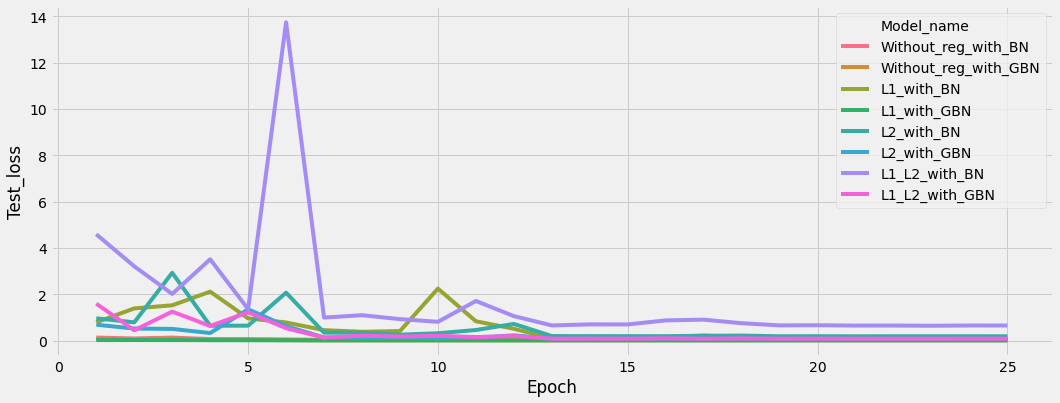

In [37]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,6))
sns.lineplot(x="Epoch",y="Test_loss",data= test_losses_df, hue= "Model_name")

# Test Accuracy

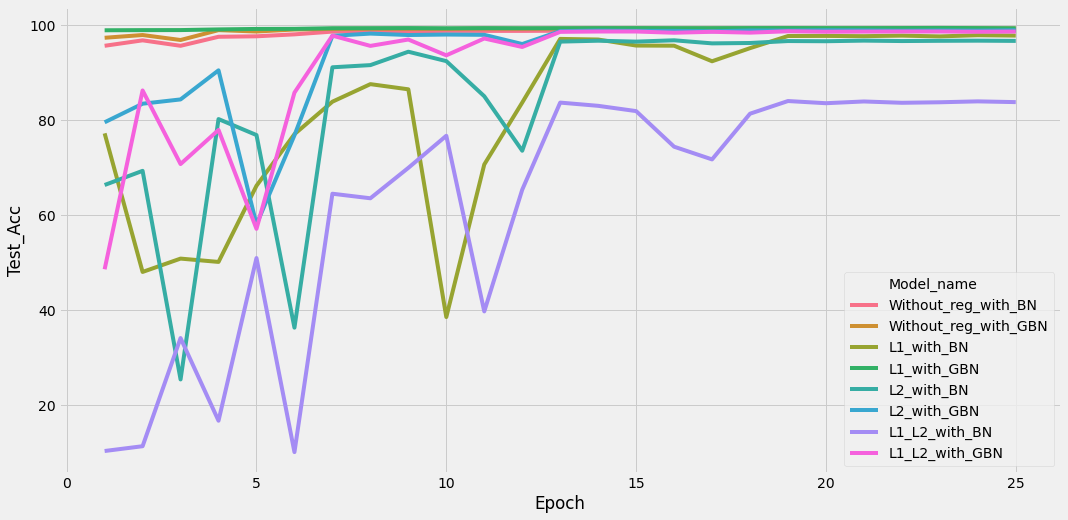

In [38]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))
sns.lineplot(x="Epoch",y="Test_Acc",data= test_accuracy_df, hue= "Model_name")

# Missclassified images for No regularization with Batch Normalization

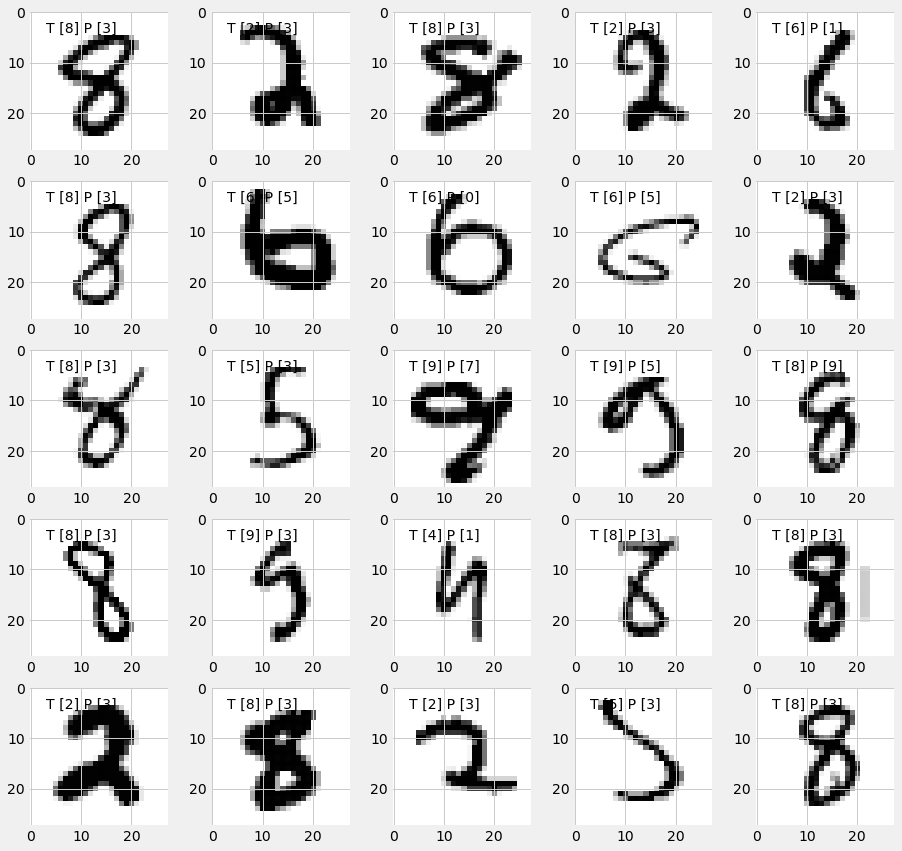

In [39]:
fig, axs = plt.subplots(5,5,figsize=(14,14))
index=0
for i in range(5):
  for j in range(5):
    data,t,p = all_miss[0][index]
    axs[i,j].imshow(data.cpu().numpy().squeeze(), cmap='gray_r')
    axs[i,j].annotate("T "+str(t.cpu().numpy())+" P "+str(p.cpu().numpy()),(3,4))
    index+=1;

# Missclassified images for no regularization with GBN

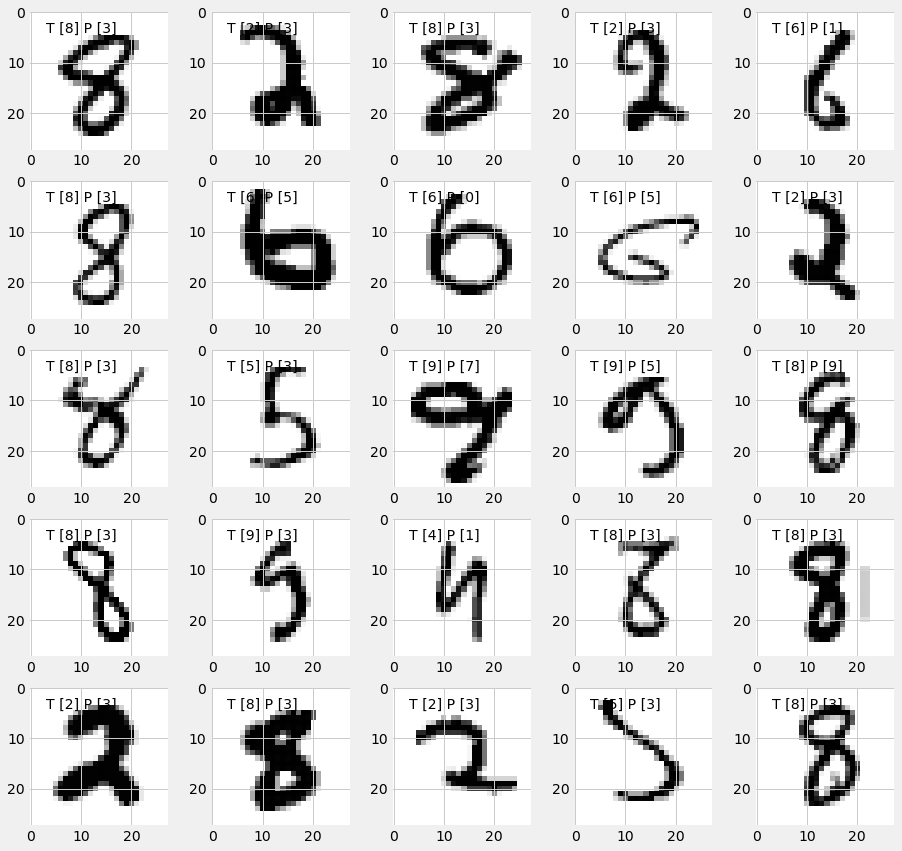

In [40]:

fig, axs = plt.subplots(5,5,figsize=(14,14))
index=0
for i in range(0,5):
  for j in range(0,5):
    data,t,p = all_miss[1][index]
    axs[i,j].imshow(data.cpu().numpy().squeeze(), cmap='gray_r')
    axs[i,j].annotate("T "+str(t.cpu().numpy())+" P "+str(p.cpu().numpy()),(3,4))
    index+=1;